In [111]:
from tensorflow.keras.datasets import mnist
import torch.nn as nn
import torch.optim as optim
import torch

((train_images, train_labels),(test_images,test_labels)) = mnist.load_data()

train_vectors = torch.from_numpy(train_labels[:300]).long()

test_vectors = torch.from_numpy(test_labels[:1]).long()

train_images = torch.from_numpy(train_images[:300]).float()
test_images = torch.from_numpy(test_images[:1]).float()

In [112]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.cnn = nn.Sequential(
        nn.Conv2d(1, 32, 2),
        nn.MaxPool2d(4, 4),
        nn.Conv2d(32, 64, 2),
        nn.MaxPool2d(4, 4),
        nn.Flatten(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16, 10),
        )

    def forward(self,x):
        x = x.reshape(-1,1,28,28)
        return self.cnn(x)


In [113]:
cnn = Model()

loss_func =  nn.CrossEntropyLoss()

optimizer = optim.Adam(cnn.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [114]:
for epoch in range(100):
    total_loss = 0
    test_loss = 0
    for i in range(int(len(train_images)/100)):
        optimizer.zero_grad()
        image = train_images[100*i:100*i+100]
        label = train_vectors[100*i:100*i+100]
        output = cnn(image)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("At epoch", epoch)
    print('loss is ', total_loss)
    print('test loss is ', test_loss)
    scheduler.step()


At epoch 0
loss is  36.51106071472168
test loss is  0
At epoch 1
loss is  16.43012285232544
test loss is  0
At epoch 2
loss is  11.441105127334595
test loss is  0
At epoch 3
loss is  10.048935890197754
test loss is  0
At epoch 4
loss is  7.976653337478638
test loss is  0
At epoch 5
loss is  6.70651912689209
test loss is  0
At epoch 6
loss is  6.525296688079834
test loss is  0
At epoch 7
loss is  6.361404180526733
test loss is  0
At epoch 8
loss is  6.256752252578735
test loss is  0
At epoch 9
loss is  6.1825268268585205
test loss is  0
At epoch 10
loss is  6.090020418167114
test loss is  0
At epoch 11
loss is  5.9980868101119995
test loss is  0
At epoch 12
loss is  5.9299808740615845
test loss is  0
At epoch 13
loss is  5.868455290794373
test loss is  0
At epoch 14
loss is  5.80046284198761
test loss is  0
At epoch 15
loss is  5.730339884757996
test loss is  0
At epoch 16
loss is  5.665704727172852
test loss is  0
At epoch 17
loss is  5.606614589691162
test loss is  0
At epoch 18
loss 

tensor([[[ 0.1508, -0.3052],
         [-0.1136, -0.0110]]])



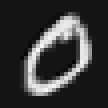
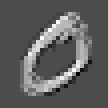
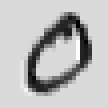
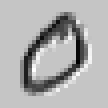
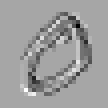
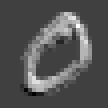
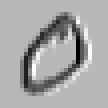
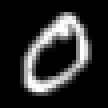
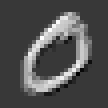
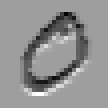
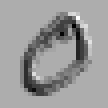
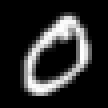
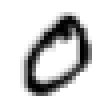
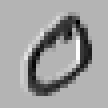
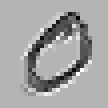
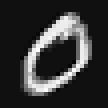
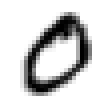
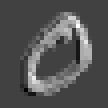
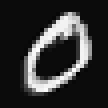
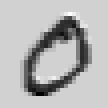
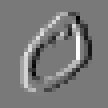
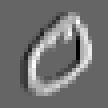
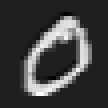
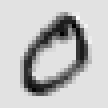
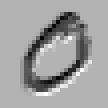
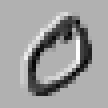
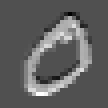
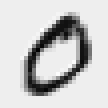
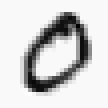
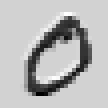
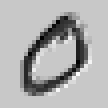
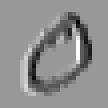

In [115]:
import numpy as np
import base64
from PIL import Image
from IPython.display import HTML, display

# ---- Helper: normalize, convert to PIL, scale up ----
def to_pil(img, scale=4):
    img_uint8 = (255 * (img - img.min()) / (img.max() - img.min())).astype(np.uint8)
    pil_img = Image.fromarray(img_uint8)
    return pil_img.resize((pil_img.width * scale, pil_img.height * scale), Image.NEAREST)

# ---- Helper: display PIL images side by side ----
def show_side_by_side(imgs, size=80, per_row=8):
    html = ""
    for i in range(0, len(imgs), per_row):
        row_imgs = ''.join(
            f'<img src="data:image/png;base64,{base64.b64encode(im._repr_png_()).decode("ascii")}" '
            f'style="margin:2px; width:{size}px;">'
            for im in imgs[i:i+per_row]
        )
        html += f"<div>{row_imgs}</div>"
    display(HTML(html))

# ---- Example: extract 32 feature maps from CNN ----
images = []
conv = cnn.cnn[0]
print(conv.weight.data[-2])
feature_maps = conv(train_images[1].reshape(-1, 1, 28, 28))

for i in range(32):
    fmap = feature_maps[0][i].detach().numpy()
    images.append(to_pil(fmap, scale=4))

# ---- Display all maps in a grid (8 per row) ----
show_side_by_side(images, size=80, per_row=8)



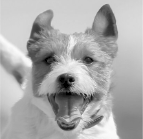
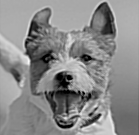

In [129]:
import torch
import torch.nn as nn
import cv2
from PIL import Image
from IPython.display import HTML, display
import base64

# ---- Helper: display side by side ----
def show_side_by_side(imgs, size=200):
    html = ''.join(
        f'<img src="data:image/png;base64,{base64.b64encode(im._repr_png_()).decode("ascii")}" '
        f'style="margin:5px; width:{size}px;">'
        for im in imgs
    )
    display(HTML(f"<div>{html}</div>"))

# ---- 1. Load image (grayscale) ----
img = cv2.imread("Image.png", cv2.IMREAD_GRAYSCALE)

# Convert to tensor [1, 1, H, W]
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# ---- 2. Define Laplacian kernel (edges in all directions) ----
kernel = torch.tensor([[-1, -1, -1, -1, -1],
 [-1,  2,  2,  2, -1],
 [-1,  2,  8,  2, -1],
 [-1,  2,  2,  2, -1],
 [-1, -1, -1, -1, -1]])/ 8

kernel = kernel.view(1, 1, 5, 5)  # shape [out_ch, in_ch, H, W]

# Convolution layer with fixed kernel
conv = nn.Conv2d(1, 1, kernel_size=5, bias=False)
with torch.no_grad():
    conv.weight.copy_(kernel)

# ---- 3. Apply convolution ----
edge_map = conv(img_tensor)

# ---- 4. Post-process: clamp negatives → normalize 0–255 ----
edge_map = edge_map.squeeze()
edge_map = torch.clamp(edge_map, min=0)        # keep background black
edge_map = (edge_map / edge_map.max()) * 255   # scale to 0–255
edge_map = edge_map.byte().cpu().numpy()

# ---- 5. Convert to PIL and display ----
orig_pil = Image.fromarray(img)
edge_pil = Image.fromarray(edge_map)

show_side_by_side([orig_pil, edge_pil], size=200)
